https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2023/04-evaluation/homework.md

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`

In [285]:
from tqdm.auto import tqdm

In [286]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [287]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [288]:
def load_data():
    return pd.read_csv('car_price_data-w4.csv')

In [289]:
def prepare_columns_names(df):
    data = df.copy()
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    return data

In [290]:
def prepare_string_column_values(df):
    data = df.copy()
    strings = list(data.dtypes[data.dtypes == 'object'].index)

    for col in strings:
        data[col] = data[col].str.lower().str.replace(' ', '_')
        data[col] = data[col].str.lower().str.replace('/', '_')
    
    return data

In [291]:
def fill_missing_values_with_zero(df):
    return df.fillna(0)

In [292]:
def calc_confusion_table_values(y_val, y_pred, threshold=0.5):
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= threshold)
    predict_negative = (y_pred < threshold)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    return tp, tn, fp, fn

In [293]:
def vectorize(df, sparse=False):
    dv = DictVectorizer(sparse=sparse)

    df_dict = df.to_dict(orient='records')
    X = dv.fit_transform(df_dict)    

    return dv, X

In [294]:
def vectorize_and_train(df_train, y_train, C=1.0, random_state=None):
    dv, X_train = vectorize(df_train)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=random_state)
    model.fit(X_train, y_train)

    return dv, model

In [295]:
hw_columns = [
    'make',
    'model',
    'year',
    'engine_hp',
    'engine_cylinders',
    'transmission_type',
    'vehicle_style',
    'highway_mpg',
    'city_mpg',
    'msrp'
]

### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [296]:
df_raw = load_data()

In [297]:
# Prepare Data
df = prepare_columns_names(df_raw)
df = prepare_string_column_values(df)

df = df[hw_columns]
df = fill_missing_values_with_zero(df)
# df = df.rename(columns={'msrp': 'price'})

price_avg = df.msrp.mean()
df['above_average'] = (df.msrp > price_avg).astype(int)

df.head(2)

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,46135,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,40650,1


In [298]:
random_state = 1

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_state)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

for col in ['msrp', 'above_average']:
    del df_train[col]
    del df_val[col]
    del df_test[col]

In [299]:
df_train[:1].T

,0
make,toyota
model,highlander_hybrid
year,2016
engine_hp,280.0
engine_cylinders,6.0
transmission_type,automatic
vehicle_style,4dr_suv
highway_mpg,28
city_mpg,27


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp` <=
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [300]:
columns = [
    'engine_hp',
    'engine_cylinders',        
    'highway_mpg',
    'city_mpg'
]

for col in columns:
    dv, model = vectorize_and_train(df_train[[col]], y_train)
    X_val = dv.transform(df_val[[col]].to_dict(orient='records'))
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    print(f"auc: {score.round(4):<6}  - {col}")

auc: 0.9153  - engine_hp
auc: 0.7691  - engine_cylinders
auc: 0.6286  - highway_mpg
auc: 0.67    - city_mpg


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- <mark>0.979</mark>

In [301]:
dv, model = vectorize_and_train(df_train, y_train)

X_val = dv.transform(df_val.to_dict(orient='records'))
y_pred = model.predict_proba(X_val)[:, 1]

auc: 0.9796



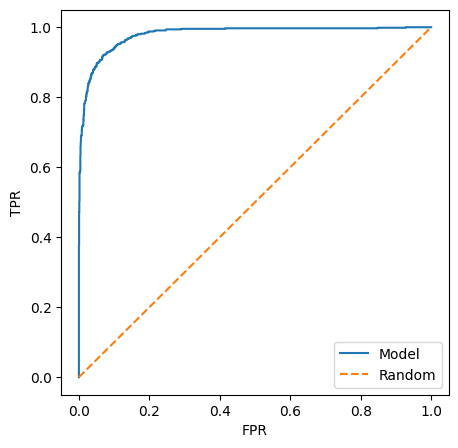

In [302]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print(f"auc: {auc(fpr, tpr).round(4)}")
print()

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* <mark>0.48</mark>
* 0.68
* 0.88

In [303]:
dv, model = vectorize_and_train(df_train, y_train)

X_val = dv.transform(df_val.to_dict(orient='records'))
y_pred = model.predict_proba(X_val)[:, 1]

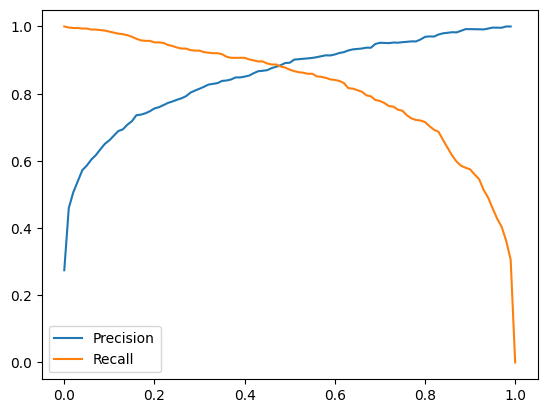

In [304]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    tp, tn, fp, fn = calc_confusion_table_values(y_val, y_pred, t)
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- <mark>0.52</mark>
- 0.72


In [305]:
dv, model = vectorize_and_train(df_train, y_train)

X_val = dv.transform(df_val.to_dict(orient='records'))
y_pred = model.predict_proba(X_val)[:, 1]

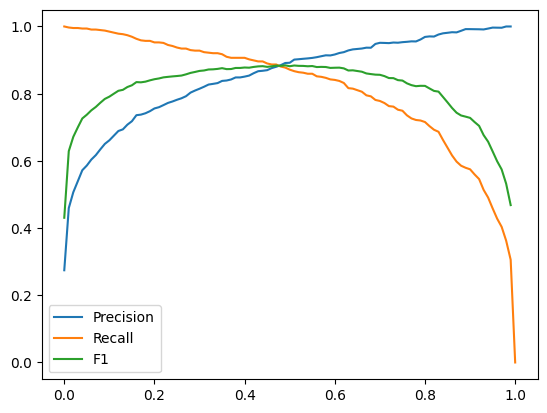

In [306]:
scores = []
thresholds = np.linspace(0, 1, 101)

f1_max = 0
f1_threshold = 0

for t in thresholds:
    tp, tn, fp, fn = calc_confusion_table_values(y_val, y_pred, t)
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['f1'] = 2 * (df_scores.p * df_scores.r / (df_scores.p + df_scores.r))

plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.plot(df_scores.threshold, df_scores['f1'], label='F1')
plt.legend()

In [307]:
selected_thresholds = [0.12, 0.32, 0.52, 0.72]

In [308]:
df_scores[df_scores['threshold'].isin(selected_thresholds)]

,threshold,tp,fp,fn,tn,p,r,f1
12,0.12,640,289,14,1440,0.688913,0.978593,0.808591
32,0.32,603,126,51,1603,0.827160,0.922018,0.872017
52,0.52,565,61,89,1668,0.902556,0.863914,0.882812
72,0.72,499,26,155,1703,0.950476,0.762997,0.846480


In [309]:
idx = df_scores[df_scores['threshold'].isin(selected_thresholds)]['f1'].idxmax()
row = df_scores.iloc[idx]
row

threshold       0.520000
tp            565.000000
fp             61.000000
fn             89.000000
tn           1668.000000
p               0.902556
r               0.863914
f1              0.882812
Name: 52, dtype: float64

In [310]:
idx = df_scores['f1'].idxmax()
row = df_scores.iloc[idx]
row

threshold       0.490000
tp            574.000000
fp             70.000000
fn             80.000000
tn           1659.000000
p               0.891304
r               0.877676
f1              0.884438
Name: 49, dtype: float64

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- <mark>0.003</mark>
- 0.030
- 0.090
- 0.140

In [269]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    for col in ['msrp', 'above_average']:
        del df_train[col]
        del df_val[col]

    dv, model = vectorize_and_train(df_train, y_train)
    X_val = dv.transform(df_val.to_dict(orient='records'))
    y_pred = model.predict_proba(X_val)[:, 1]            

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('auc: %.5f, mean: %.5f, std: %.3f' % (auc, np.mean(scores), np.std(scores)))

auc: 0.97768, mean: 0.97880, std: 0.002


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- <mark>10</mark>

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [284]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
    
        for col in ['msrp', 'above_average']:
            del df_train[col]
            del df_val[col]
    
        dv, model = vectorize_and_train(df_train, y_train, C)
        X_val = dv.transform(df_val.to_dict(orient='records'))
        y_pred = model.predict_proba(X_val)[:, 1]            
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C: %.2f, auc: %.5f, mean: %.3f, std: %.3f' % (C, auc, np.mean(scores).round(3), np.std(scores).round(3)))

 25%|█████████████████████████████                                                                                       | 1/4 [00:00<00:01,  1.70it/s]

C: 0.01, auc: 0.95024, mean: 0.952, std: 0.002


 50%|██████████████████████████████████████████████████████████                                                          | 2/4 [00:01<00:01,  1.61it/s]

C: 0.10, auc: 0.97338, mean: 0.972, std: 0.002


 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 3/4 [00:01<00:00,  1.61it/s]

C: 0.50, auc: 0.98400, mean: 0.980, std: 0.003


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.58it/s]

C: 10.00, auc: 0.97748, mean: 0.981, std: 0.002
